<a href="https://colab.research.google.com/github/robimalco/colab/blob/main/Home_Credit_Default_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADD KEYS

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "robimalco" # username from the json file
os.environ['KAGGLE_KEY'] = "8fcc61848d4025dfdb164ec737d7166e" # key from the json file
!pip install -q kaggle
!kaggle competitions download -c home-credit-default-risk

 92% 52.0M/56.8M [00:01<00:00, 20.6MB/s]
100% 56.8M/56.8M [00:02<00:00, 29.5MB/s]
 68% 25.0M/36.8M [00:00<00:00, 50.8MB/s]
100% 36.8M/36.8M [00:00<00:00, 68.2MB/s]
 97% 105M/109M [00:02<00:00, 40.2MB/s] 
100% 109M/109M [00:02<00:00, 42.6MB/s]
  0% 0.00/524k [00:00<?, ?B/s]
100% 524k/524k [00:00<00:00, 173MB/s]
 92% 89.0M/96.7M [00:03<00:00, 17.4MB/s]
100% 96.7M/96.7M [00:03<00:00, 29.2MB/s]
  0% 0.00/36.5k [00:00<?, ?B/s]
100% 36.5k/36.5k [00:00<00:00, 28.7MB/s]
 97% 35.0M/36.1M [00:00<00:00, 49.0MB/s]
100% 36.1M/36.1M [00:00<00:00, 52.6MB/s]
 85% 65.0M/76.3M [00:02<00:00, 33.1MB/s]
100% 76.3M/76.3M [00:02<00:00, 37.8MB/s]
 95% 257M/271M [00:03<00:00, 56.1MB/s]
100% 271M/271M [00:03<00:00, 80.5MB/s]
 69% 4.00M/5.81M [00:00<00:00, 39.7MB/s]
100% 5.81M/5.81M [00:00<00:00, 51.9MB/s]


# START SETUP

In [ ]:
!unzip application_test.csv.zip
!unzip application_train.csv.zip
# !unzip POS_CASH_balance.csv.zip
# !unzip bureau.csv.zip
# !unzip bureau_balance.csv.zip
# !unzip credit_card_balance.csv.zip
# !unzip installments_payments.csv.zip
# !unzip previous_application.csv.zip

In [4]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install torchvision

In [5]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Files

*   application_{train|test}.csv --> main table, static data for all applications. One row represents one loan in our data sample.
*   bureau.csv -->  client's previous credits, for every loan in our sample, there are as many rows as number of credits the client had.
*   bureau_balance.csv --> monthly balances of previous credits, one row for each month.
*   POS_CASH_balance.csv --> monthly balance snapshots of previous point of sales and cash loans that the applicant had, one row for each month.
*   credit_card_balance.csv --> monthly balance snapshots of previous credit cards, one row for each month.
*   previous_application.csv --> all previous applications for Home Credit loans of clients who have loans.
*   installments_payments.csv --> repayment history for the previously disbursed credits.

# Load all data into pandas dataframes

In [150]:
application_train_df = pd.read_csv('application_train.csv')
application_test_df = pd.read_csv('application_test.csv')
# bureau_df = pd.read_csv('bureau.csv')
# bureau_balance_df = pd.read_csv('bureau_balance.csv')
# pos_cash_balance_df = pd.read_csv('POS_CASH_balance.csv')
# credit_card_balance_df = pd.read_csv('credit_card_balance.csv')
# previous_application_df = pd.read_csv('previous_application.csv')
# installments_payments_df = pd.read_csv('installments_payments.csv')

In [9]:
# application_train_df = application_train_df.head(20000)
# application_test_df = application_test_df.head(2000)

In [179]:
application_train_df['CSV_SOURCE'] = 'application_train.csv'
application_test_df['CSV_SOURCE'] = 'application_test.csv'
temp_df = pd.concat([application_train_df, application_test_df])

In [180]:
# Quick estimation of approval_rate
rejected = application_train_df[application_train_df['TARGET'] == 0].shape[0]
approved = application_train_df[application_train_df['TARGET'] == 1].shape[0]
approval_rate = round(approved/(approved+rejected)*100)
print("approval_rate%", approval_rate)

approval_rate% 8


# Function utilities

In [169]:
def split_columns_by_type(input_df):
  numerical_columns = []
  categorical_columns = []
  for column in input_df.columns:
    if input_df.dtypes[column] == np.int64 or input_df.dtypes[column] == np.float64:
      numerical_columns.append(column)
    else:
      categorical_columns.append(column)
  return numerical_columns, categorical_columns

In [170]:
# threshold = 60
def convert_numerical_to_categorical(input_df):
  for column in input_df.columns:
    if column == 'TARGET':
      pass
    elif input_df.dtypes[column] == np.int64 or input_df.dtypes[column] == np.float64:
      if len(input_df[column].unique()) < 60:
        input_df[column] = input_df[column].astype('string')
  return input_df

In [171]:
def smart_overview(input_df):
  a_types = []
  a_countUnique = []
  a_missing = []
  a_missing_perc = []
  a_corrTarget = []
  a_min = []
  a_max = []
  a_mean = []
  a_quantile = []
  for column in input_df.columns:
    x = input_df[column]
    x_type = input_df.dtypes[column]
    countUnique = len(x.unique())
    missing = x.isnull().sum()
    missing_perc = round((missing/input_df.shape[0]),3)*100
    if x_type == np.int64 or x_type == np.float64:
      a_corrTarget.append(round(x.corr(input_df['TARGET']), 3))
      a_min.append(x.min())
      a_max.append(x.max())
      a_mean.append(x.mean())
      a_quantile.append(x.quantile(0.5))
    else:
      a_corrTarget.append('')
      a_min.append('')
      a_max.append('')
      a_mean.append('')
      a_quantile.append('')
    a_types.append(x_type)
    a_countUnique.append(countUnique)
    a_missing.append(missing)
    a_missing_perc.append(missing_perc)
  explore_df = pd.DataFrame({
    'Columns': input_df.columns,
    'Types': a_types,
    'Unique': a_countUnique,
    'Missing': a_missing,
    'Missing%': a_missing_perc,
    'CorrTarget': a_corrTarget,
    'Min': a_min,
    'Max': a_max,
    'Mean': a_mean,
    'Quantile': a_quantile
  })
  explore_df.set_index('Columns', inplace=True)
  return explore_df.transpose()

# Data Exploration

## application_{train|test}.csv

In [181]:
# Order column alphabetically
temp_df_columns = list(temp_df.columns)
temp_df_columns.sort()
temp_df = temp_df[temp_df_columns]

In [182]:
# Define categorical and numerical columns
temp_df = convert_numerical_to_categorical(temp_df)
temp_columns_type = split_columns_by_type(temp_df)
temp_numerical_columns = temp_columns_type[0]
temp_categorical_columns = temp_columns_type[1]

In [184]:
"""

# Because they have values
temp_numerical_columns = ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 
  'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION']

# Without NULL
temp_categorical_columns = ['CODE_GENDER', 'CSV_SOURCE', 'FLAG_CONT_MOBILE',
  'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_PHONE',
  'FLAG_WORK_PHONE', 'LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION',
  'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE',
  'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
  'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION', 'WEEKDAY_APPR_PROCESS_START', 'TARGET']

"""

temp_numerical_columns = ['AMT_ANNUITY', 'AMT_CREDIT']
temp_categorical_columns = ['CODE_GENDER', 'CSV_SOURCE', 'FLAG_OWN_CAR',
  'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
  'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE']
temp_target_column = ['TARGET']

In [185]:
# KEEP ONLY RELEVAN COLUMNS
temp_df = temp_df[temp_target_column + temp_categorical_columns + temp_numerical_columns]

In [186]:
# Apply mean to missing values in numerical columns

for numerical_column in temp_numerical_columns:
  temp_df[numerical_column].fillna(value=temp_df[numerical_column].median(), inplace=True)

In [187]:
# STANDARDISATION EXAMPLE
min_max_scaler = preprocessing.MinMaxScaler()
temp_df[temp_numerical_columns] = pd.DataFrame(min_max_scaler.fit_transform(temp_df[temp_numerical_columns]))

In [28]:
# smart_overview(temp_df)

# temp_df.hist(figsize=(24,20), bins=100)
# plt.show()

In [188]:
pd.options.mode.chained_assignment = None

temp_categorical_columns.remove('CSV_SOURCE')

for column in temp_categorical_columns:
  temp_df[column] = LabelEncoder().fit_transform(temp_df[column].astype(str))
for column in temp_categorical_columns:
  temp_df[column] = temp_df[column].astype('category')

In [189]:
train_temp_df = temp_df[temp_df['CSV_SOURCE'] == 'application_train.csv']
train_output_temp_df = pd.DataFrame(train_temp_df['TARGET'], columns=['TARGET'])

test_temp_df = temp_df[temp_df['CSV_SOURCE'] == 'application_test.csv']

train_temp_df.drop(columns=['CSV_SOURCE', 'TARGET'], axis=0, inplace=True)
test_temp_df.drop(columns=['CSV_SOURCE', 'TARGET'], axis=0, inplace=True)

In [194]:
def create_categorical_tensor(input_df):
  stack = []
  for column in temp_categorical_columns:
    temp_stack = input_df[column].cat.codes.values
    stack.append(temp_stack)
  return torch.tensor(np.stack(stack, 1), dtype=torch.float)

def create_numerical_tensor(input_df):
  stack = []
  for column in temp_numerical_columns:
    temp_stack = input_df[column].astype(np.float64)
    stack.append(temp_stack)
  return torch.tensor(np.stack(stack, 1), dtype=torch.float)


tensor_train_categorical = create_categorical_tensor(train_temp_df[temp_categorical_columns]).float()
tensor_train_numerical = create_numerical_tensor(train_temp_df[temp_numerical_columns]).float()
tensor_train_output = torch.tensor(train_output_temp_df.values).flatten().float()

tensor_test_categorical = create_categorical_tensor(test_temp_df[temp_categorical_columns]).float()
tensor_test_numerical = create_numerical_tensor(test_temp_df[temp_numerical_columns]).float()

In [195]:
total_records_train = len(train_temp_df)
test_records_train = int(total_records_train * 0.2)

tensor_train_categorical_data = tensor_train_categorical[:total_records_train-test_records_train].to(device)
tensor_train_numerical_data = tensor_train_numerical[:total_records_train-test_records_train].to(device)
tensor_train_output = tensor_train_output[:total_records_train-test_records_train].to(device)

tensor_validation_categorical_data = tensor_train_categorical[total_records_train-test_records_train:total_records_train].to(device)
tensor_validation_numerical_data = tensor_train_numerical[total_records_train-test_records_train:total_records_train].to(device)
tensor_validation_output = tensor_train_output[:total_records_train-(total_records_train-test_records_train)].to(device)

In [196]:
categorical_columns_size = [len(temp_df[column].astype('category').cat.categories) for column in temp_categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_columns_size]
# categorical_embedding_sizes

In [197]:
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

train_data = TensorDataset(tensor_train_categorical_data, tensor_train_numerical_data, tensor_train_output)
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

In [198]:
class Model(nn.Module):
  def __init__(self, embedding_size, num_numerical_cols, layers, ps):
    super().__init__()

    self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
    self.emb_drop = nn.Dropout(0.04)
    self.bn_cont = nn.BatchNorm1d(num_numerical_cols)

    num_categorical_cols = sum((nf for ni, nf in embedding_size))
    input_size = num_categorical_cols + num_numerical_cols

    layerlist = []
    for i, elem in enumerate(layers):
      layerlist.append(nn.Linear(input_size, elem))
      layerlist.append(nn.ReLU(inplace=True))
      layerlist.append(nn.BatchNorm1d(layers[i]))
      layerlist.append(nn.Dropout(ps[i]))
      input_size = elem
    layerlist.append(nn.Linear(layers[-1], 1))

    self.layers = nn.Sequential(*layerlist)

  def forward(self, x_categorical, x_numerical):

    embeddings = []
    for i,e in enumerate(self.all_embeddings):
        embeddings.append(e(x_categorical[:,i].long()))

    x = torch.cat(embeddings, 1)
    x = self.emb_drop(x)

    x_numerical = self.bn_cont(x_numerical)

    x = torch.cat([x, x_numerical], 1)
    x = self.layers(x)

    return x

In [ ]:
num_numerical_cols = tensor_train_numerical_data.shape[1]

model = Model(categorical_embedding_sizes, num_numerical_cols, layers=[1000,500], ps=[0.001,0.01])
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)

In [202]:
# Train

n_epochs = 10

for epoch in range(n_epochs):
  losses = []
  for x_cat, x_num, y in train_loader:
    y_pred = model(x_cat, x_num)
    single_loss = torch.sqrt(loss_function(y_pred.squeeze(), y))
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
    losses.append(single_loss.item())
  print("epoch: " + str(epoch) + "\tloss: " + str(1.0 * sum(losses) / len(losses)))

epoch: 0	loss: 0.24907278147861475
epoch: 1	loss: 0.2390864946910521
epoch: 2	loss: 0.23817670228993665
epoch: 3	loss: 0.23767345136733503
epoch: 4	loss: 0.23867501056207197
epoch: 5	loss: 0.23857653210048685
epoch: 6	loss: 0.23921548680792226
epoch: 7	loss: 0.23881255620146133
epoch: 8	loss: 0.23859213882495472
epoch: 9	loss: 0.23801598809538643


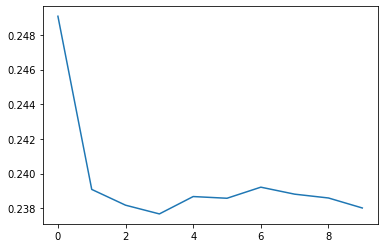

In [204]:
l = [0.24907278147861475,0.2390864946910521,0.23817670228993665,
     0.23767345136733503,0.23867501056207197,0.23857653210048685,
     0.23921548680792226,0.23881255620146133,0.23859213882495472,
     0.23801598809538643]
plt.plot(l)
plt.show()

In [206]:
# Validate

validation_data = TensorDataset(tensor_validation_categorical_data, tensor_validation_numerical_data, tensor_validation_output)
validation_loader = DataLoader(dataset=validation_data, batch_size=16, shuffle=True)

losses = []

with torch.no_grad():
  for x_cat, x_num, y in validation_loader:
    y_valid = model(x_cat, x_num)
    validation_loss = torch.sqrt(loss_function(y_valid.squeeze(), y))
    losses.append(validation_loss.item())
  print("loss: " + str(1.0 * sum(losses) / len(losses)))

loss: 0.23511044131243033


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f552047ac18>]],
      dtype=object)

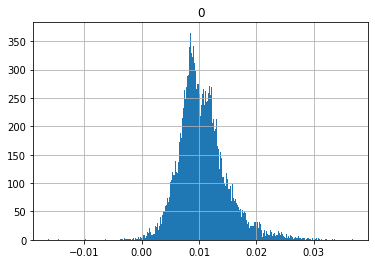

In [207]:
# Predict

with torch.no_grad():
  tensor_test_categorical_data = tensor_test_categorical.to(device)
  tensor_test_numerical_data = tensor_test_numerical.to(device)
  y_pred = model(tensor_test_categorical_data, tensor_test_numerical_data)
pd.DataFrame(y_pred).astype("float").hist(bins=1000)

In [208]:
prediction_df = pd.DataFrame(y_pred).astype("float")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(prediction_df)
prediction_df = pd.DataFrame(x_scaled)
prediction_df = pd.concat([prediction_df, application_test_df['SK_ID_CURR']], axis=1)
prediction_df.columns = ['TEMP_TARGET', 'SK_ID_CURR']
prediction_df['TARGET'] = round(prediction_df['TEMP_TARGET'], 1)
prediction_df = prediction_df[['SK_ID_CURR', 'TARGET']]
print("mean:", str(prediction_df['TARGET'].mean()))
prediction_df.groupby(by=['TARGET'])['TARGET'].count()

mean: 0.507081897259164


TARGET
0.0        3
0.1        4
0.2       32
0.3      602
0.4    10193
0.5    26223
0.6     9141
0.7     1909
0.8      537
0.9       94
1.0        6
Name: TARGET, dtype: int64

In [209]:
from google.colab import files

submission_df = prediction_df[['SK_ID_CURR', 'TARGET']]
submission_df.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>